<div style="text-align:center">
    <img title="Contest title" alt="An image show Kaggle's contest title" src="./figures/contest_title.png">

<!-- [image source](https://www.google.com/search?q=Google+Analytics+Customer+Revenue+Prediction+image&sca_esv=592634044&tbm=isch&sxsrf=AM9HkKlftHgD8SLQdTaxoZl26nouayB7dg:1703109603032&source=lnms&sa=X&ved=2ahUKEwi2ypvXgZ-DAxX_jGMGHRMoAUIQ_AUoAXoECAEQAw&biw=1707&bih=809&dpr=1.5#imgrc=uoakpuQba4-QtM) -->
</div>

<div style="text-align: center; background-color: #5A96E3; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  ĐỒ ÁN CUỐI KỲ - LẬP TRÌNH CHO KHOA HỌC DỮ LIỆU
</div>

<div style="text-align: center; background-color: #559cff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  <ins>Giai đoạn 3</ins>: Phân tích Khám phá Dữ liệu (EDA)
</div>

---
#

<div style="font-family: american typewriter, serif; line-height: 1.5; word-spacing: 4px;">

# **MỤC LỤC**

</div>

[**0. CÁC THƯ VIỆN CẦN SỬ DỤNG**](#0)<br />
[**1. ĐỌC DỮ LIỆU ĐÃ ĐƯỢC LÀM SẠCH TỪ FILE**](#1)<br />
[**2. ĐƯA RA CÁC CÂU HỎI CẦN TRẢ LỜI CÙNG VỚI LỢI ÍCH KHI TRẢ LỜI CÂU HỎI ĐÓ**](#2)<br />
&emsp;&emsp;● [**Câu hỏi 1**](#q1_q)<br />
&emsp;&emsp;● [**Câu hỏi 2**](#q2_q)<br />
&emsp;&emsp;● [**Câu hỏi 3**](#q3_q)<br />
&emsp;&emsp;● [**Câu hỏi 4**](#q4_q)<br />
&emsp;&emsp;● [**Câu hỏi 5**](#q5_q)<br />
[**3. TIỀN XỬ LÝ VÀ PHÂN TÍCH DỮ LIỆU ĐỂ TRẢ LỜI TỪNG CÂU HỎI**](#3)<br />
&emsp;&emsp;● [**Câu hỏi 1**](#q1_a)<br />
&emsp;&emsp;● [**Câu hỏi 2**](#q2_a)<br />
&emsp;&emsp;● [**Câu hỏi 3**](#q3_a)<br />
&emsp;&emsp;● [**Câu hỏi 4**](#q4_a)<br />
&emsp;&emsp;● [**Câu hỏi 5**](#q5_a)<br />

---
#

<div style="font-family: american typewriter, serif; line-height: 1.5; word-spacing: 4px;">

# **0. CÁC THƯ VIỆN CẦN SỬ DỤNG** <a class="anchor" id="0"></a>

</div>

In [1]:
# Common libraries
import numpy as np
import pandas as pd
import re
import json

# Seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas
sns.set()

# Plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

init_notebook_mode(connected=True)

---
#

<div style="font-family: american typewriter, serif; line-height: 1.5; word-spacing: 4px;">

# **1. ĐỌC DỮ LIỆU ĐÃ ĐƯỢC LÀM SẠCH TỪ FILE** <a class="anchor" id="1"></a>

</div>

In [2]:
cleaned_df = pd.read_csv("../data/processed/train_preprocessed.csv")

In [3]:
# TEST
cleaned_df.sample(n=5)

,channelGrouping,date,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,...,totals.newVisits,totals.transactionRevenue,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,date.day,date.year,date.month,date.weekDay,date.weekOfYear
678093,Organic Search,2017-07-13,1,Chrome,Windows,False,desktop,Europe,Western Europe,France,...,True,0.0,google,organic,False,13,2017,7,3,28
863973,Organic Search,2017-03-26,1,Chrome,Android,True,mobile,Asia,Southern Asia,India,...,True,0.0,google,organic,False,26,2017,3,6,12
642960,Paid Search,2017-02-09,1,Chrome,Windows,False,desktop,Americas,Northern America,United States,...,True,0.0,google,cpc,False,9,2017,2,3,6
263171,Organic Search,2016-12-03,1,Chrome,iOS,True,mobile,Americas,Northern America,United States,...,True,0.0,google,organic,False,3,2016,12,5,48
378517,Organic Search,2016-12-07,1,Safari,iOS,True,tablet,Asia,Southern Asia,India,...,True,0.0,google,organic,False,7,2016,12,2,49


In [4]:
# TEST
cleaned_df.shape

(903653, 25)

Sau khi có cái nhìn tổng quát về dữ liệu, ta sẽ đưa ra một vài câu hỏi mà có thể trả lời bằng cách phân tích dữ liệu để có cái nhìn sâu sắc hơn về tập dữ liệu mà ta đang làm việc.

---
#

<div style="font-family: american typewriter, serif; line-height: 1.5; word-spacing: 4px;">

# **2. ĐƯA RA CÁC CÂU HỎI CẦN TRẢ LỜI CÙNG VỚI LỢI ÍCH KHI TRẢ LỜI CÂU HỎI ĐÓ** <a class="anchor" id="2"></a>

</div>

<!-- Đưa ra các câu hỏi cần trả lời cùng với lợi ích khi trả lời câu hỏi đó -->

### <a class="anchor" id="q1_q"></a><ins>**Câu hỏi 1**</ins>: Tỉ lệ chi tiêu của mỗi quốc gia so với tổng quốc gia và tỉ lệ số lần mua của từng quốc gia so với tổng quốc gia như thế nào? 

**Lợi ích**: Trả lời câu hỏi trên sẽ giúp ta đánh giá được các quốc gia có lượng chi tiêu lớn cũng như các quốc gia có số lượng mua nhiều, qua đó giúp có chiến lược quảng cáo tốt hơn, tập trung vào các khu vực có số lượng mua lớn cũng như tăng số lượng mua của khu vực đó lên.

⭐[<b><i>Trả lời câu hỏi 1</i></b>](#q1_a)

### <a class="anchor" id="q2_q"></a><ins>**Câu hỏi 2**</ins>: Các kiểu tiếp cận khác nhau ảnh hưởng như thế nào đến số tiền chi tiêu và số lần chi tiêu của người dùng? 

**Lợi ích**: Trả lời câu hỏi trên sẽ giúp chúng ta đánh giá được sự ảnh hưởng của cách thức tiếp cận của khách hàng và sự chi tiêu của khách hàng; qua đó có thể có những ưu đãi đặc biệt cho những phương thức này.

⭐[<b><i>Trả lời câu hỏi 2</i></b>](#q2_a)

### <a class="anchor" id="q3_q"></a><ins>**Câu hỏi 3**</ins>: Liệu người dùng có xu hướng chi tiêu nhiều hơn khi tiếp tục xem các sản phẩm được liên kết đến sản phẩm hiện tại không? 

**Lợi ích**: Trả lời câu hỏi trên sẽ giúp chúng ta đánh giá được tâm lí chi tiêu của khác hàng qua đó có thể có những ưu đãi đặc biệt cũng như việc liên kết các sản phẩm với nhau.

⭐[<b><i>Trả lời câu hỏi 3</i></b>](#q3_a)

### <a class="anchor" id="q4_q"></a><ins>**Câu hỏi 4**</ins>: Vào khoảng thời gian nào thì người dùng có xu hướng truy cập thường xuyên và sẵn sàng chi tiêu nhiều hơn để mua sắm các sản phẩm từ cửa hàng của Google? 

**Trả lời câu hỏi này sẽ giúp chúng ta**: hiểu rõ hơn về xu hướng chi tiêu của người dùng và những thời điểm tiềm năng mà người dùng có khả năng chi tiêu nhiều hơn để mua sản phẩm từ cửa hàng. Đây là thông tin vô cùng cần thiết giúp các chiến dịch marketing dễ dàng tiếp cận và thu hút được sự chú ý từ người dùng, nâng cao khả năng tăng doanh thu cho cửa hàng.

⭐[<b><i>Trả lời câu hỏi 4</i></b>](#q4_a)

### <a class="anchor" id="q5_q"></a><ins>**Câu hỏi 5**</ins>: Người dùng thường sử dụng thiết bị với các thông số kỹ thuật như thế nào khi truy cập vào cửa hàng của Google? Liệu có tồn tại một loại thiết bị với thông số kỹ thuật đặc thù nào đó mà khi sử dụng nó, người dùng có xu hướng mua hàng nhiều hơn hay không? 

<class style="font-size: 20px;">

> **TÓM TẮT**  
> - Trả lời câu hỏi này sẽ mang lại nhiều lợi ích:
>
>   + <ins>Với nhóm phát triển ứng dụng</ins>: Khi hiểu rõ hơn về thói quen của người dùng thì ta có thể tối ưu hóa ứng dụng giúp nâng cao trải nghiệm của người dùng. Đồng thời giúp ứng dụng có thể tiếp cận với nhiều người dùng hơn...
>
>   + <ins>Với nhóm làm chiến dịch quảng cáo</ins>: Việc hiểu rõ hơn về người dùng giúp ta xác định khách hàng tiềm năng hiệu quả hơn. Khi này, ta có thể tối ưu hóa chiến dịch quảng cáo, chính sách ưu đãi dựa vào thông tin thiết bị của họ.

</class>

(Ghi chú: Đây là các thông tin mà có thể BIẾT ĐƯỢC ngay từ khi người dùng bắt đầu phiên truy cập của mình.)

**Trả lời câu hỏi này sẽ mang lại lợi ích cho chúng ta ở nhiều khía cạnh khác nhau, bao gồm**:
- <ins>Với nhóm phát triển ứng dụng (website)</ins>: Khi ta hiểu rõ hơn về thói quen, nhu cầu của người dùng thì ta có thể phát triển, tối ưu hóa ứng dụng của mình để nó chạy tốt trên các thiết bị phổ biến. Điều này giúp nâng cao trải nghiệm sử dụng của người dùng, và đồng thời giúp ứng dụng của chúng ta có thể tiếp cận với nhiều người dùng hơn.

- <ins>Với nhóm làm chiến dịch quảng cáo</ins>: Việc hiểu rõ hơn về đối tượng mục tiêu của mình sẽ giúp ta có thể xác định các khách hàng tiềm năng hiệu quả hơn. Khi này, ta có thể tối ưu hóa chiến dịch quảng cáo, điều chỉnh các chính sách ưu đãi dựa vào thông tin thiết bị của người dùng. Điều này giúp tối đa hóa lợi nhuận từ cùng một nguồn vốn nhất định.

⭐[<b><i>Trả lời câu hỏi 5</i></b>](#q5_a)

---
#

<div style="font-family: american typewriter, serif; line-height: 1.5; word-spacing: 4px;">

# **3. TIỀN XỬ LÝ VÀ PHÂN TÍCH DỮ LIỆU ĐỂ TRẢ LỜI TỪNG CÂU HỎI** <a class="anchor" id="3"></a>

</div>

<!-- Sau đó, ta sẽ tiền xử lý và phân tích dữ liệu để trả lời từng câu hỏi -->

### <a class="anchor" id="q1_a"></a><ins>**Câu hỏi 1**</ins>: Tỉ lệ chi tiêu của mỗi quốc gia so với tổng quốc gia và tỉ lệ số lần mua của từng quốc gia so với tổng quốc gia như thế nào?

#### Thực hiện

Với mỗi quốc gia tính:

s1 (tỉ lệ số tiền chi) = số tiền quốc gia chi / số tiền toàn thế giới chi

s2 (tỉ lệ số lần truy cập) = số lần truy cập của quốc gia / số lần truy cập toàn thế giới

s3 (tỉ lệ số lần mua) = số lần mua hàng của quốc gia / số lần mua hàng của thế giới


tỉ lệ 1 = s1/s2

tỉ lệ 2 = s3/s2

Sau đó ta vẽ hai geochart thể hiện 2 tỉ lệ trên cho từng quốc gia, và vẽ 2 bar chart cho top 5 quốc gia cho từng tỉ lệ. 

#### Tiền xử lý (nếu cần):

#### Phân tích dữ liệu để trả lời câu hỏi

In [5]:
label = 'geoNetwork.country'

# Tạo một DataFrame mới chỉ chứa cột 'totals.transactionRevenue' và 'geoNetwork.country'
subset_df = cleaned_df[[label, 'totals.transactionRevenue']].copy()

# Tính tổng theo nhóm 'geoNetwork.country' và tính tổng tổng doanh thu
grouped = subset_df.groupby(label)['totals.transactionRevenue']
sum_data = grouped.sum().fillna(0)
total_revenue = sum_data.sum()

# Tính tỉ lệ theo từng điều kiện
s1 = sum_data / total_revenue
s2 = grouped.count() / len(subset_df)
s3 = grouped.apply(lambda x: (x > 0).sum()) / subset_df['totals.transactionRevenue'].gt(0).sum()

# Tính các giá trị cuối cùng và lưu vào DataFrame values
t1 = s1 / s2
t2 = s3 / s2
values = pd.DataFrame({'Country': s1.index, 'T1': t1.values, 'T2': t2.values})

/tmp/ipykernel_24421/1953471943.py:18: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



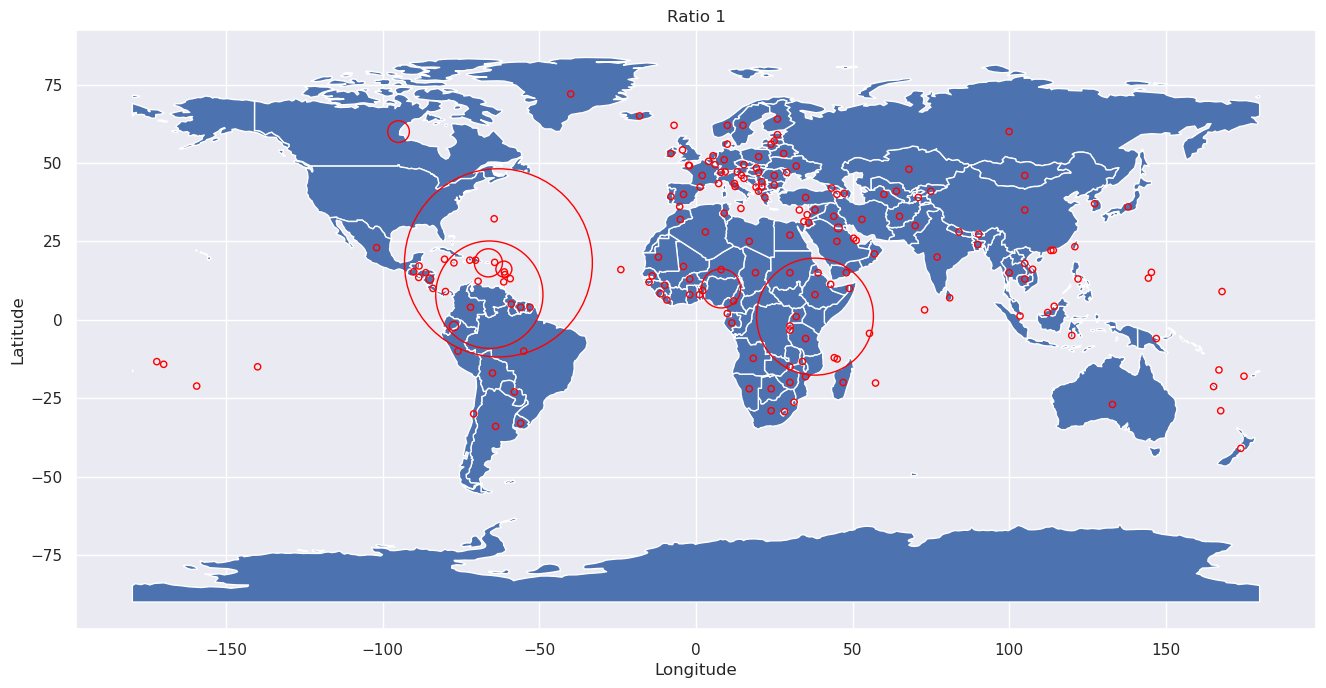

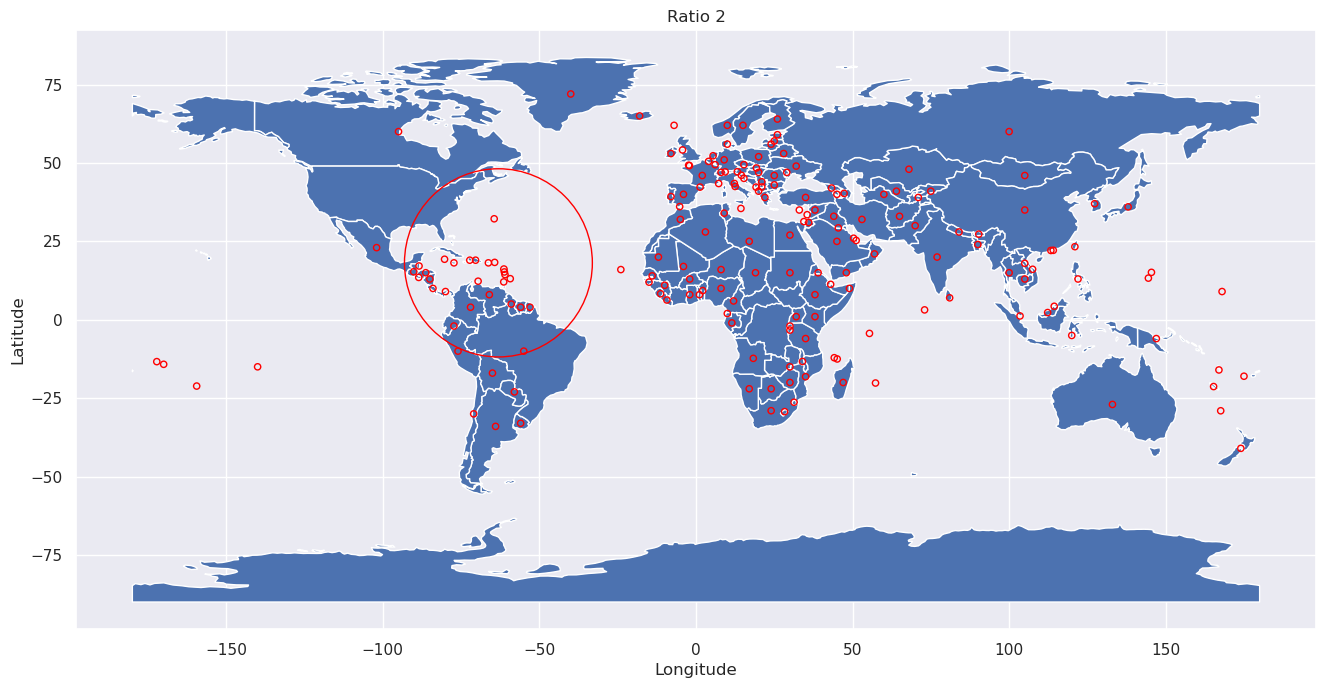

In [6]:
#Vẽ 2 biểu đồ

money_df = values.copy()
money_df.columns = ['Country', 'Ratio 1', 'Ratio 2']

with open('../data/external/coord.json') as file:
    coordinates = json.load(file)

coord_data = {
    'Country': list(coordinates['lat'].keys()),
    'Latitude': list(coordinates['lat'].values()),
    'Longitude': list(coordinates['long'].values())
}

coord_df = pd.DataFrame(coord_data)
merged_df = pd.merge(money_df, coord_df, on='Country')

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


# Ratio 1
m_ratio_1 = np.max(merged_df['Ratio 1'])
fig, ax = plt.subplots(figsize=(16, 12))
world.plot(ax=ax)
for ind in merged_df.index:
    circle = plt.Circle((merged_df['Longitude'][ind], merged_df['Latitude'][ind]), max(merged_df['Ratio 1'][ind] / m_ratio_1 * 30, 1), color='red', fill=False)
    ax.add_patch(circle)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Ratio 1')
plt.grid(True)
plt.show()
# Ratio 2
m_ratio_2 = np.max(merged_df['Ratio 2'])
fig, ax = plt.subplots(figsize=(16, 12))
world.plot(ax=ax)
for ind in merged_df.index:
    circle = plt.Circle((merged_df['Longitude'][ind], merged_df['Latitude'][ind]), max(merged_df['Ratio 2'][ind] / m_ratio_2 * 30, 1), color='red', fill=False)
    ax.add_patch(circle)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Ratio 2')
plt.grid(True)
plt.show()

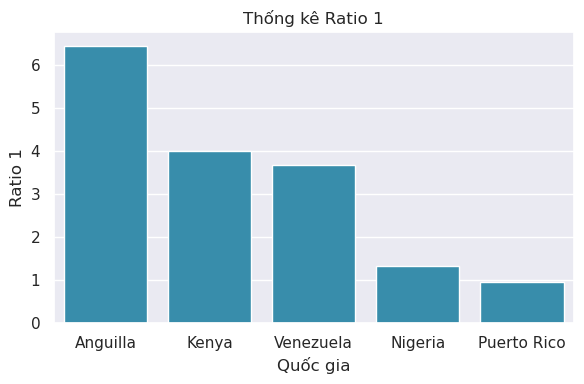

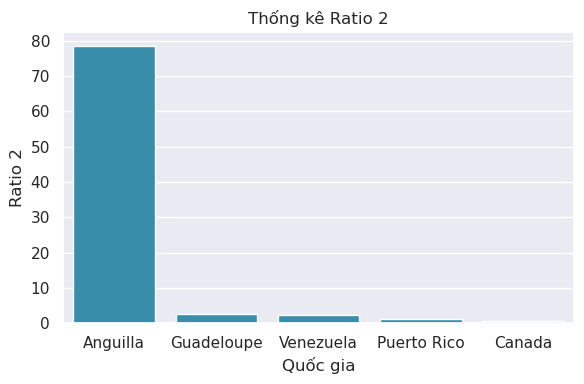

In [7]:
#Vẽ biểu đồ cột cho các quốc gia có tỉ lê cao nhất
fields = ['Ratio 1', 'Ratio 2']

# Create subplots for each field
for field in fields:
    # Sort values for the current field in descending order
    sorted_df = merged_df.sort_values(by=field, ascending=False).head(5)

    # Create bar plot using Seaborn
    plt.figure(figsize=(6, 4))
    sns.barplot(x='Country', y=field, data=sorted_df, color='#2596be')
    plt.title(f'Thống kê {field}')
    plt.xlabel('Quốc gia')
    plt.ylabel(field)
    plt.tight_layout()
    plt.show()

> **Nhận xét**: Ta thấy được rằng chỉ có một số ít quốc gia có tỉ lệ chi tiêu lớn và chỉ có một quốc gia có tỉ lệ lần mua nhiều. Anguilla là quốc gia có cả 2 tỉ lệ ở mức lớn hơn rất nhiều so với toàn thế giới. Ngoài ra một số quốc gia như: Kenya, Venezuela, Nigeria, Puerto Rico có tỉ lệ chi tiêu rất lớn so với tỉ lệ số lần mua.

---

### <a class="anchor" id="q2_a"></a><ins>**Câu hỏi 2**</ins>: Các kiểu tiếp cận khác nhau ảnh hưởng như thế nào đến số tiền chi tiêu và số lần chi tiêu của người dùng?

#### Thực hiện

Với mỗi quốc giá trị riêng biệt trong 3 cột: 'trafficSource.source', 'trafficSource.medium', 'trafficSource.isTrueDirect' ta tính:

s1 (tỉ lệ số tiền chi) = số tiền giá trị chi / số tiền toàn thế giới chi

s2 (tỉ lệ số lần truy cập) = số lần truy cập của giá trị / số lần truy cập toàn thế giới

s3 (tỉ lệ số lần mua) = số lần mua hàng của giá trị / số lần mua hàng của thế giới


tỉ lệ 1 = s1/s2

tỉ lệ 2 = s3/s2

Sau đó ta vẽ 2 bar chart cho top 5 giá trị cho từng tỉ lệ. 

#### Tiền xử lý (nếu cần)

#### Phân tích dữ liệu để trả lời câu hỏi

Source


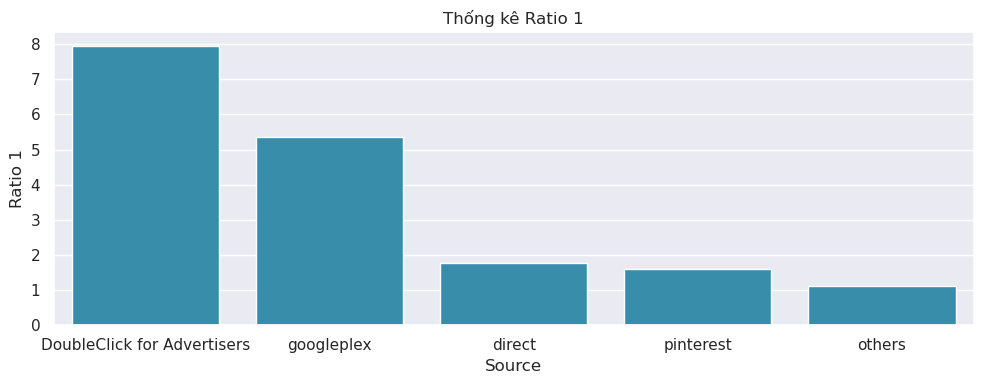

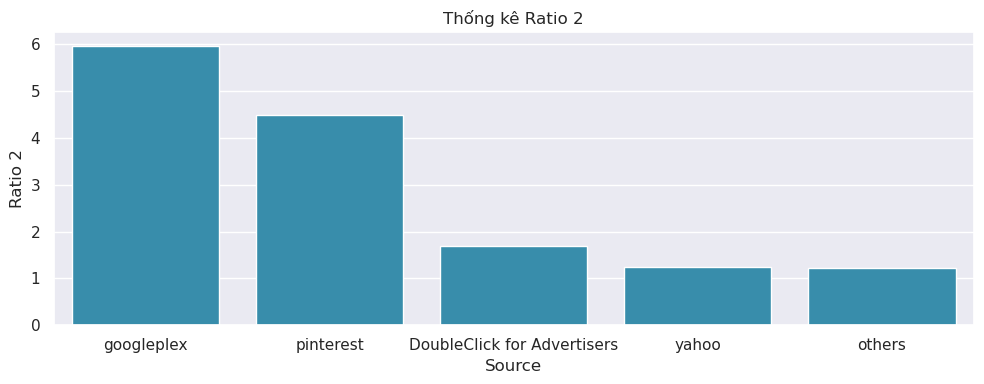

Medium


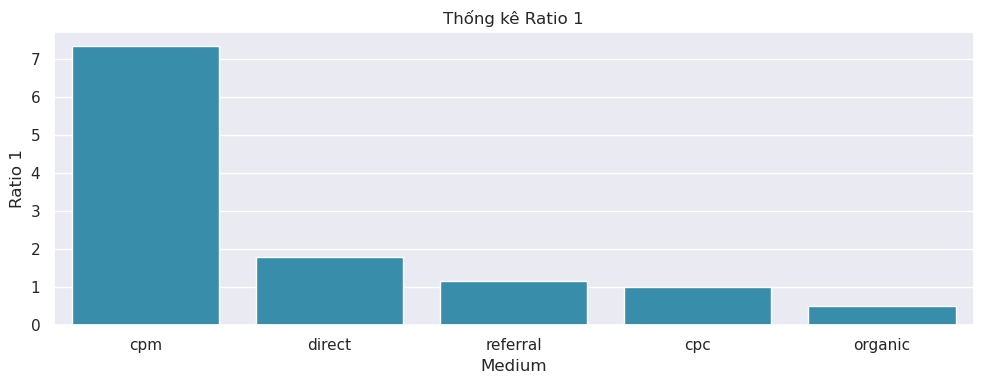

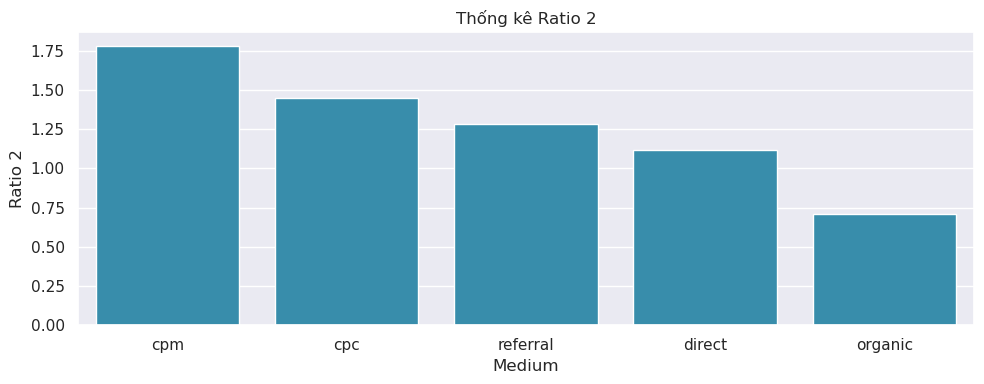

In [8]:
labels = ['trafficSource.source', 'trafficSource.medium']

trafficSource_df = []

for label in labels:
    l = cleaned_df[label].copy()
    unis = l.unique()
    data = cleaned_df['totals.transactionRevenue'].copy()

    values = []

    for uni in unis:
        s1 = sum(data[l == uni]) / sum(data)
        s2 = sum(l == uni) / len(l)
        s3 = sum((l == uni) & (data > 0)) / sum(data > 0)
        t1 = s1 / s2
        t2 = s3 / s2
        values.append((uni, t1, t2))
    trafficSource_df.append(pd.DataFrame(values))

trafficSource_df[0].columns = ['Source', 'Ratio 1', 'Ratio 2']
trafficSource_df[1].columns = ['Medium', 'Ratio 1', 'Ratio 2']

fields = ['Ratio 1', 'Ratio 2']

# Create subplots for each field
for df in trafficSource_df:
    print(df.columns[0])
    for field in fields:
        # Sort values for the current field in descending order
        sorted_df = df.sort_values(by=field, ascending=False).head(5)

        # Create bar plot using Seaborn
        plt.figure(figsize=(10, 4))
        sns.barplot(x=df.columns[0], y=field, data=sorted_df, color='#2596be')
        plt.title(f'Thống kê {field}')
        plt.xlabel(df.columns[0])
        plt.ylabel(field)
        plt.tight_layout()
        plt.show()

> **Nhận xét**:
> * Source: có sự khác biệt lớn giữa 2 tỉ lệ, Double clicks for advertise có tỉ lệ số tiền chi tiêu rất lớn nhưng tỉ lệ của số lần chi lại nhỏ hơn đáng kệ, các khách hàng dùng phương thức này có xu hướng chi nhiều tiền cho 1 lần chi. Direct source có tỉ lệ số tiền chi tiêu lớn so với tỉ lệ số lần chi tiêu, tỉ lệ số lần chi tiêu của phương thức này còn không nằm trong 5 phương thức phổ biến nhất, điều này thể hiện việc các chi tiêu của người dùng ít khi đến trực tiếp từ việc họ biết trước sản phẩm cần mua và thường sẽ thông qua các hình thức quảng cáo, tìm kiếm.
>
> * Medium: Tỉ lệ về số lần chi tiêu các các thuộc tính hàng đầu xấp xỉ tương tự nhau, thuy nhiên tỉ lệ về số tiền chi tiêu lại có sự chênh lệch rất lớn giữa cpm và các thuộc tính khác. Điều này cho thấy hình thức cpm có hiệu quá rất tốt.

---

### <a class="anchor" id="q3_a"></a><ins>**Câu hỏi 3**</ins>: Liệu người dùng có xu hướng chi tiêu nhiều hơn khi tiếp tục xem các sản phẩm được liên kết đến sản phẩm hiện tại không?

#### Thực hiện

Ta sẽ vẽ hai biểu đồ lần lượt thể hiện sự tương quan giữa số trang truy cập đến số tiền chi cũng như khả năng chi tiền của khác hàng.

#### Tiền xử lý (nếu cần)

In [9]:
total_df = cleaned_df[['totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits', 'totals.transactionRevenue']].copy()
#create new columns of is_transaction
total_df['totals.is_transaction'] = total_df['totals.transactionRevenue'].apply(lambda x: 1 if x > 0 else 0)

#### Phân tích dữ liệu để trả lời câu hỏi

<Axes: xlabel='totals.pageviews'>

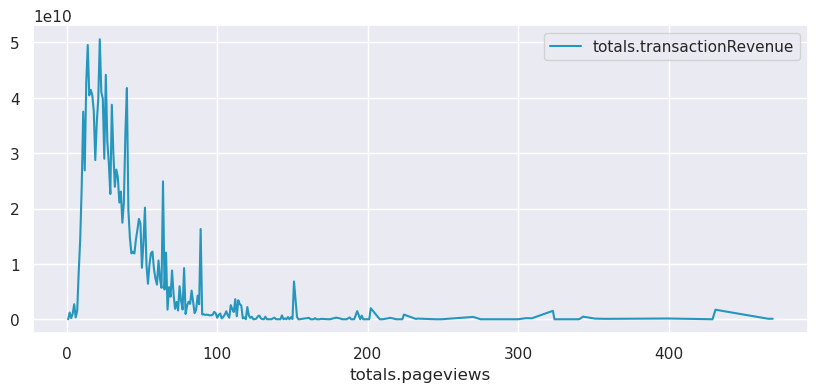

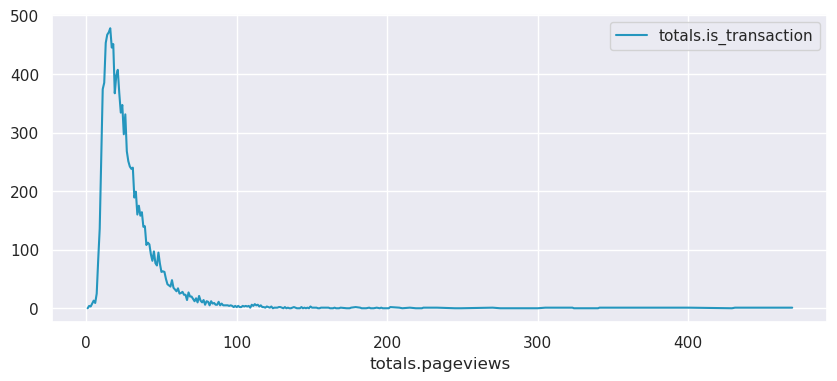

In [10]:
#create a new dataframe groupby total.hits with total.transactionRevenue
df = total_df[['totals.pageviews', 'totals.transactionRevenue', 'totals.is_transaction']].groupby('totals.pageviews').sum().reset_index()
df.plot(x='totals.pageviews', y='totals.transactionRevenue', figsize=(10, 4), color='#2596be')
df.plot(x='totals.pageviews', y='totals.is_transaction', figsize=(10, 4), color='#2596be')

In [11]:
max_page = df[df['totals.transactionRevenue'] == df['totals.transactionRevenue'].max()]['totals.pageviews'].values[0]

print(f'Khả năng mua hàng cũng như số tiền chi đạt tối da khi số trang web truy cập là {max_page} lần')

Khả năng mua hàng cũng như số tiền chi đạt tối da khi số trang web truy cập là 22 lần


> **Nhận xét**: Ta thấy rằng số tiền chi cũng như khả năng chi tiền của khác hàng tăng mạnh và sau đó giảm nhanh với số trang web mà họ truy cập. Qua đó ta thấy được rằng khách hàng sẽ có khả năng mua hàng rất cao nếu họ tiếp tục truy cập đến những sản phẩm liên quan đến sản phẩm hiện tại. Tuy nhiên khả năng này sẽ giảm đáng kể nếu như người dùng tiếp tục truy cập đến các sản phẩm liên quan tiếp theo.

---

### <a class="anchor" id="q4_a"></a><ins>**Câu hỏi 4**</ins>: Vào khoảng thời gian nào thì người dùng có xu hướng truy cập thường xuyên và sẵn sàng chi tiêu nhiều hơn để mua sắm các sản phẩm từ cửa hàng của Google?

#### Ý tưởng thực hiện

- Ta sẽ dùng các thuộc tính phân loại đã trích xuất từ cột `date` trong notebook `02` để trả lời cho câu hỏi này.
- Với mỗi thuộc tính mà ta quan tâm, ta sẽ lần lượt thực hiện 3 bước:
    + Bước 1: Ta thực hiện thống kê một số giá trị như: `tổng số lượt truy cập`, `số lần truy cập có giao dịch` và `tổng giá trị giao dịch` cho mỗi giá trị trong thuộc tính mà ta quan tâm.
    + Bước 2: Ta sẽ sử dụng các biểu đồ như: `bar-chart` hoặc `line-chart` để so sánh các giá trị thống kê bên trên giữa các mốc thời gian.
    + Bước 3: Quan sát biểu đồ và đưa ra nhận xét, đồng thời trả lời câu hỏi nêu trên. 

#### Tiền xử lý (nếu cần)

#### Phân tích dữ liệu để trả lời cho câu hỏi

Đầu tiên, ta xây dựng một hàm tiện ích giúp đơn giản quá trình thống kê dựa trên thuộc tính mà ta quan tâm

In [12]:
def _create_feature_stats(df: pd.DataFrame, feature: str) -> pd.DataFrame:
    """Create a dataframe contains: 
        1. Number of visits per unique value in `feature`,
        2. Number of non-zero revenue visits per unique value in `feature` 
        3. Total revenue per unique value in `feature`.
    """
    # Create 3 dataframes
    counts = df[feature].value_counts().to_frame().reset_index()\
                .sort_values(feature).rename(columns={'count': 'visits'})

    non_zero_counts = \
        df.query("`totals.transactionRevenue` > 0")[feature]\
            .value_counts().to_frame().reset_index()\
                .sort_values(feature).rename(columns={'count': 'non_zero_transactions'})
    
    sums = df.groupby(feature)['totals.transactionRevenue'].sum()\
                .to_frame().reset_index().sort_values(feature)

    # Merge 3 dataframes
    merged_df = pd.merge(counts, non_zero_counts, on=feature, how='left')
    merged_df = pd.merge(merged_df, sums, on=feature, how='left')
    
    return merged_df

##### 1. Phân bố theo `ngày trong tháng`

In [13]:
# Get some useful statistics from `date.day` column
day_stats = _create_feature_stats(cleaned_df, 'date.day')

# Plot bar charts
BASIC_PLOTLY_CONFIG = dict(
    title_x=0.5, title_font_size=20,
    xaxis=dict(tickmode='linear', tick0=0, dtick=1),
    coloraxis_showscale=False,
    xaxis_title_font_size=20, xaxis_tickfont_size=16,
    yaxis_title_font_size=20, yaxis_tickfont_size=16,
)
# ====================  For `visits` ==================== 
fig = px.bar(
    day_stats, x="date.day", y="visits",
    color='visits', hover_name='visits',
    labels={'date.day': 'Day', 'visits': '#Visits'},
    color_continuous_scale=px.colors.sequential.Tealgrn,
    height=400, width=800
)
fig.layout.update(
    BASIC_PLOTLY_CONFIG |
    dict(title_text='<b>Visits by day</b>', 
         xaxis_title='Day of month', yaxis_title='# Visits')
)
iplot(fig)

# ====================  For `non_zero_transactions` ====================
fig = px.bar(
    day_stats, x="date.day", y="non_zero_transactions",
    color='non_zero_transactions', hover_name='non_zero_transactions',
    labels={'date.day':'Day', 'non_zero_transactions':'#Non-zero transactions'},
    color_continuous_scale=px.colors.sequential.Blues,
    height=400, width=800
)
fig.layout.update(
    BASIC_PLOTLY_CONFIG |
    dict(title_text='<b>Non-zero transactions by day</b>', 
         xaxis_title='Day of month', yaxis_title='# Non-zero transactions')
)
iplot(fig)

# ====================  For `totals.transactionRevenue` ====================
fig = px.bar(
    day_stats, x="date.day", y="totals.transactionRevenue",
    color='totals.transactionRevenue', hover_name='totals.transactionRevenue',
    labels={'date.day': 'Day', 'totals.transactionRevenue': 'ΣRevenue'},
    color_continuous_scale=px.colors.sequential.Pinkyl,
    height=400, width=800
)
fig.layout.update(
    BASIC_PLOTLY_CONFIG |
    dict(title_text='<b>Transaction revenue by day</b>', 
         xaxis_title='Day of month', yaxis_title='Σ Revenue')
)
# iplot(fig)
fig.show()

> 💭 <u>**Nhận xét**</u>: 
> * Về tổng số lượt truy cập: Nhìn chung, tổng số lượng truy cập của người dùng vào GStore là không quá khác biệt giữa các ngày trong tháng. Ta thấy ngày 31 có số lượng truy cập thấp hơn hẳn những ngày khác, điều này cũng bình thường vì 1 năm chỉ có 7 tháng là có ngày thứ 31.
>
> * Về số lượt truy cập có giao dịch: Có vẻ như người dùng thường có tỉ lệ chi trả nhiều hơn vào các ngày giữa tháng (khoảng từ ngày 5 $\to$ 20 hàng tháng). Ngược lại, khả năng một người dùng chịu chi trả tiền vào cuối tháng thường tương đối thấp.
>
> * Về doanh thu theo từng ngày trong tháng: Cũng không ngoài dự đoán, các ngày có tỉ lệ người dùng chi trả cao hơn thì cũng có tổng doanh thu cao hơn. Tổng doanh thu của cửa hàng thường tập trung từ ngày 5 $\to$ 20 hàng tháng. Giai đoạn chuyển tiếp từ cuối tháng trước đến đầu tháng sau thường có tổng doanh thu không cao.
>
> * Tuy nhiên, các ngày trong tháng không mang tính phổ quát quá cao nên ta cần quan sát thêm các thông tin khác để có thể nắm bắt thói quen của khách hàng.

##### 2. Phân bố theo `ngày trong tuần`

In [14]:
# Get some useful statistics from `date.weekDay` column
weekDay_stats = _create_feature_stats(cleaned_df, 'date.weekDay')

# Change value of `date.weekDay` to meaningful name
WEEK_DAY = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekDay_stats['date.weekDay'] \
    = weekDay_stats['date.weekDay'].apply(lambda x: WEEK_DAY[x])

# Plot bar chart
# ====================  For `visits` ==================== 
fig = px.bar(
    weekDay_stats, x="date.weekDay", y="visits",
    color='visits', hover_name='visits',
    labels={'date.weekDay': 'DayOfWeek', 'visits': '#Visits'},
    color_continuous_scale=px.colors.sequential.Tealgrn,
    height=420, width=680
)
fig.layout.update(
    BASIC_PLOTLY_CONFIG |
    dict(title_text='<b>Visits by Day-of-week </b>',
         xaxis_title='Day of week', yaxis_title='# Visits')
)
iplot(fig)

# ====================  For `non_zero_transactions` ==================== 
fig = px.bar(
    weekDay_stats, x="date.weekDay", y="non_zero_transactions",
    color='non_zero_transactions', hover_name='non_zero_transactions',
    labels={'date.weekDay': 'DayOfWeek', 'non_zero_transactions': '#Non-zero transactions'},
    color_continuous_scale=px.colors.sequential.Viridis,
    height=420, width=680
)
fig.layout.update(
    BASIC_PLOTLY_CONFIG |
    dict(title_text='<b>Non-zero transactions by Day-of-week</b>',
         xaxis_title='Day of week', yaxis_title='# Non-zero transactions')
)
iplot(fig)

# ====================  For `totals.transactionRevenue` ====================
fig = px.bar(
    weekDay_stats, x="date.weekDay", y="totals.transactionRevenue",
    color='totals.transactionRevenue', hover_name='totals.transactionRevenue',
    labels={'date.weekDay': 'DayOfWeek', 'totals.transactionRevenue': 'ΣRevenue'},
    color_continuous_scale=px.colors.sequential.Peach,
    height=420, width=680
)
fig.layout.update(
    BASIC_PLOTLY_CONFIG |
    dict(title_text='<b>Transaction revenue by Day-of-week</b>',
         xaxis_title='Day of week', yaxis_title='Σ Revenue')
)
iplot(fig)

> 💭 <u>**Nhận xét**</u>: 
> * Nhìn vào ba biểu đồ ở trên, ta phát hiện một điểm chung đáng chú ý: các ngày trong tuần (từ thứ 2 $\to$ 6) thường có số lượng truy cập vào cửa hàng, số lượng phiên giao dịch và tổng doanh thu nhiều hơn so với thứ 7 và chủ nhật. 
>
> * Ta biết rằng phần lớn mọi người thường đi làm vào các ngày trong tuần và nghỉ vào cuối tuần, việc một lượng lớn khách hàng tiềm năng thường xuất hiện vào các ngày trong tuần có thể đến từ các khoảng thời gian nghỉ ngơi trong giờ làm việc. Khi này, người đi làm sẽ có chút ít thời gian rãnh rỗi để lên mạng xã hội, xem tin tức và ghé qua các cửa hàng để xem quần áo, v.v. Dẫn đến phần lớn doanh thu của cửa hàng đều xuất phát từ các ngày trong tuần. 
>
> * Còn vào các ngày cuối tuần, mọi thường có kế hoạch nghỉ ngơi, vui chơi riêng bên cạnh người thân, bạn bè nên họ thường không dành nhiều thời gian để lên mạng. Điều này có thể lý giải cho số lượng truy cập và tổng doanh thu vào thứ 7 và chủ nhật thường ít hơn hẳn các ngày trong tuần.

##### 3. Phân tích tổng quát xu hướng của người dùng trên toàn bộ tập dữ liệu

In [15]:
# Get some useful statistics from `date` column
date_stats = _create_feature_stats(cleaned_df, 'date')

# Plot bar chart
BASIC_LAYOUT_CONFIG = dict(
    title_x=0.5, title_font_size=24,
    yaxis_title_font_size=18, yaxis_tickfont_size=12,
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible=True),
        type='date'
    )
)

# ====================  For `visits` ====================
trace = go.Scatter(
    x=date_stats['date'].astype(str), y=date_stats['visits'],
    opacity=0.9, line=dict(color='#3fe0c0', shape='vh', width=2)
)
layout = dict(
    title="<b>Visits by date</b>", yaxis_title='# Visits', 
    **BASIC_LAYOUT_CONFIG
)
fig = dict(data=trace, layout=layout)
iplot(fig)

# ====================  For `non_zero_transactions` ====================
trace = go.Scatter(
    x=date_stats['date'].astype(str), y=date_stats['non_zero_transactions'],
    opacity=0.8, line=dict(color='#1068c9', shape='hvh', width=2)
)
layout = dict(
    title="<b>Non-zero transactions by date</b>", 
    yaxis_title='# Non-zero transactions',
    **BASIC_LAYOUT_CONFIG
)
fig = dict(data=trace, layout=layout)
iplot(fig)

# ====================  For `totals.transactionRevenue` ====================
trace = go.Scatter(
    x=date_stats['date'].astype(str), y=date_stats['totals.transactionRevenue'],
    opacity=0.8, line=dict(color='#ff666e', shape='spline', width=2)
)
layout = dict(
    title= "<b>Revenue by date</b>", yaxis_title='$ Revenue',
    **BASIC_LAYOUT_CONFIG
)
fig = dict(data=trace, layout=layout)
iplot(fig)

> 💭 <u>**Nhận xét**</u>: 
> * Trong phần tiền xử lý dữ liệu, ta biết được một thông tin là phần lớn người dùng truy cập đến GStore đều đến từ các quốc gia ở phương Tây. Từ kiến thức thực tế, ta đều biết các quốc gia phương Tây rất coi trọng các dịp lễ cuối năm như: Halloween, lễ Tạ ơn, Giáng sinh, năm mới, v.v. và người dân nước họ thường có các đợt nghỉ lễ kéo dài trong khoảng thời gian này. Và để chuẩn bị thật tốt cho dịp nghỉ lễ thì người dân thường có xu hướng mua sắm vật dụng cá nhân nhiều hơn.
>
> * Nhìn vào hai biểu đồ đầu tiên, ta cũng thấy rất rõ điều này. Ba tháng cuối năm (từ tháng 10 $\to$ 12) thường chứng kiến số lượng người truy cập tăng đáng kể và duy trì ở mức ổn định trong một khoảng thời gian liên tục. Con số này chỉ thực sự giảm xuống mức tiêu chuẩn khi gần kết thúc năm cũ, lúc này mọi người đều đã chuẩn bị đầy đủ vật dụng và tận hưởng kỳ nghỉ của mình nên họ không có nhu cầu mua sắm gì thêm.
>
> * Nhìn vào biểu đồ thứ hai, ta còn phát hiện một thông tin rất thú vị. Tiếp tục với câu chuyện ba tháng cuối năm, có vẻ như trong khoảng thời gian ban đầu từ tháng 10 đến gần cuối tháng 11 thì người dùng có thói quen lên cửa hàng CHỈ ĐỂ lựa chọn món hàng mình ưng ý chứ chưa quyết định bỏ tiền mua món đó. Chỉ khi bước vào giai đoạn chuyển tiếp từ tháng 11 sang mùa giáng sinh thì người dùng mới quyết định mua món hàng mà mình đã chọn trước. Thông qua biểu đồ, ta thấy khoảng thời gian từ đầu tháng 10 đến gần cuối tháng 11 thì số lượng giao dịch không thay đổi quá nhiều. Chỉ khi tháng 12 đến gần thì số lượng giao dịch mới tăng lên đáng kể. Và con số này trở về bình thường khi sắp đến giao thừa.
>
> * Vì dữ liệu doanh thu ban đầu của chúng ta có hơn *98%* giá trị bị thiếu, nên khi quan sát biểu đồ cuối cùng thì ta khó có thể nắm bắt được xu hướng cụ thể trong việc chi tiêu của khách hàng. Nhìn sơ qua dữ liệu của năm 2016 thì ta thấy tổng doanh thu của quý 4 có vẻ cao hơn quý 3 nhưng tương đối khó quan sát (và có phần gượng ép). Tuy nhiên ta vẫn nhìn thấy một xu hướng chung là người dùng sẽ sẵn sàng tiền vào các dịp lễ lớn như: giáng sinh, lễ tình nhân, v.v.
>
> * Đây là một thông tin rất hữu ích cho nhóm làm marketing, quảng cáo sản phẩm. Họ có thể đầu tư nhiều tiền hơn trong việc lên ý tưởng và tổ chức các chương trình khuyến mãi vào các dịp lễ lớn trong năm nói chung và đặc biệt là trong tháng 12 nói riêng. Biết được khách hàng thường mua sắm vào các dịp lễ cũng mở ra một thị trường tiềm năng cho các mặt hàng theo mùa, đây là cơ hội để các bên phát triển sản phẩm tận dụng hết khả năng của mình để thu được lợi nhuận từ khách hàng... Việc đầu tư phát triển sản phẩm và phát động chiến dịch quảng cáo vào những thời điểm thích hợp sẽ giúp cho những ông chủ thu được lợi nhuận cao nhất chỉ với chi phí thấp nhất.

---

### <a class="anchor" id="q5_a"></a><ins>**Câu hỏi 5**</ins>: Người dùng thường sử dụng thiết bị với các thông số kỹ thuật như thế nào khi truy cập vào cửa hàng của Google? Liệu có tồn tại một loại thiết bị với thông số kỹ thuật đặc thù nào đó mà khi sử dụng nó, người dùng có xu hướng mua hàng nhiều hơn hay không?

<class style="font-size: 20px;">

> **Ý tưởng**: Với mỗi thuộc tính con của `device`, ta thực hiện ba bước:
> - Bước 1: Ta sẽ tìm bốn chỉ số thống kê: **"tổng số lần truy cập"**, **"số lần truy cập có giao dịch"**, **"doanh thu trung bình"** và **"tổng doanh thu"** cho từng giá trị trong cột.
> - Bước 2: Vẽ biểu đồ cột thể hiện bốn chỉ số nêu trên.
> - Bước 3: Tinh chỉnh biểu đồ.

</class>

#### **Tiền xử lý (nếu cần)**

#### **Phân tích dữ liệu để trả lời cho câu hỏi**

##### 0. Ý tưởng thực hiện và các hàm tiện ích

Đầu tiện, ta tạo ra một hàm tiện ích giúp vẽ **horizontal_bar_chart**:

In [16]:
def _make_horizontal_bar_chart(count_ser: pd.Series, color: str):
    trace = go.Bar(
        y=count_ser.index[10::-1],
        x=count_ser.values[10::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

**Ý tưởng thực hiện**: Với mỗi thuộc tính con bên trong thuộc tính lớn `device`, ta sẽ lần lượt thực hiện ba bước:
- Bước 1: Ta sẽ tìm bốn chỉ số thống kê: **"tổng số lần truy cập"**, **"số lần truy cập có diễn ra giao dịch"**, **"doanh thu trung bình trong mỗi phiên truy cập"** và **"tổng doanh thu"** cho từng giá trị trong cột mà ta quan tâm.
- Bước 2: Vẽ bốn biểu đồ cột thể hiện cho bốn chỉ số nêu trên.
- Bước 3: Tinh chỉnh, bổ sung các thông tin cần thiết cho biểu đồ.

Ta có thể viết một hàm tiện ích giúp tổng quát hóa quy trình này:

In [17]:
def _device_plot(feature: str, target: str = 'totals.transactionRevenue') -> go.Figure:
    # ---------- Step 1: Feature extraction ----------
    # Using `feature` and `target` to create a new dataframe
    #   having all statistics we are interested in.
    transformed_df = cleaned_df.loc[:, [feature, target]]
    transformed_df[target] = transformed_df[target].replace(0, np.nan)

    stats_df = transformed_df.groupby(feature)[target].agg(['size', 'count', 'mean'])
    stats_df.columns = ['count', 'count_of_non_zero_revenue', 'mean_transaction_value']
    stats_df['total_revenue'] = stats_df['count_of_non_zero_revenue']\
                                    * stats_df['mean_transaction_value']

    # ---------- Step 2: Config 4 horizontal bar charts ----------
    # Bar chart for `count`
    trace_1_1 = _make_horizontal_bar_chart(
        stats_df['count'].sort_values(ascending=False), 
        'rgba(135, 206, 235, 0.95)'
    )
    # Bar chart for `count of non-zero revenue`
    trace_1_2 = _make_horizontal_bar_chart(
        stats_df['count_of_non_zero_revenue'].sort_values(ascending=False), 
        'rgba(50, 171, 96, 0.85)'
    )
    # Bar chart for `mean transaction value`
    trace_2_1 = _make_horizontal_bar_chart(
        stats_df['mean_transaction_value'].sort_values(ascending=False), 
        'rgba(246, 78, 139, 0.85)'
    )
    # Bar chart for `total revenue`
    trace_2_2 = _make_horizontal_bar_chart(
        stats_df['total_revenue'].sort_values(ascending=False), 
        'rgba(250, 128, 114, 0.95)'
    )
    
    # ---------- Step 3: Create a figure containing all charts ----------
    # https://plotly.com/python-api-reference/generated/plotly.subplots.make_subplots.html
    fig = make_subplots(
        rows=2, cols=2, start_cell='top-left',
        horizontal_spacing=0.2, vertical_spacing=0.1,
        subplot_titles=['<b># Visits</b>', '<b># Non-zero revenue visits</b>', 
                        '<b>Mean revenue</b>', '<b>Total revenue</b>'],
    )
    # Add 4 bar charts to figure
    fig.append_trace(trace_1_1, 1, 1)
    fig.append_trace(trace_1_2, 1, 2)
    fig.append_trace(trace_2_1, 2, 1)
    fig.append_trace(trace_2_2, 2, 2)
    # Update layout
    title = feature.replace('.', '').replace('device', '')
    title = title[0].upper() + title[1:]
    fig['layout'].update(height=800, width=900, 
                        paper_bgcolor='rgb(233,233,233)', 
                        title=f'<b>Device - {title} Plots</b>',
                        title_x=0.5, # https://community.plotly.com/t/title-alignment-python/30820
                        title_font_size=20,
                        )
    # https://community.plotly.com/t/setting-subplot-title-font-sizes/46612/3
    fig.for_each_xaxis(lambda axis: axis.update(tickfont_size=14))
    fig.for_each_yaxis(lambda axis: axis.update(tickfont_size=14))
    
    return fig

##### 1. Phân tích thuộc tính `deviceCategory`

In [18]:
category_fig = _device_plot('device.deviceCategory')
iplot(category_fig)

💭 <u>**Nhận xét**</u>:
- Bốn biểu đồ bên trên gần như tương đồng. Người dùng `desktop` chiếm phần lớn số lượng truy cập và là nguồn doanh thu chính của cửa hàng. Dù thiết bị `mobile` chiếm khoảng 1/4 số lượt truy cập, nhưng doanh thu từ người dùng `mobile` chưa đáp ứng được những gì ta mong đợi.

- Ta thấy thiết bị `tablet` có tiềm năng phát triển rất lớn: tuy có rất ít người dùng nhưng lại tạo ra doanh thu vô cùng ấn tượng. Giá trị giao dịch trung bình của `tablet` gần như tương đồng với `mobile`. Như vậy, ta có thể đẩy mạnh đầu tư vào các chiến dịch quảng cáo dành cho người dùng `tablet` để khai thác hết tiềm năng này.

<class style="font-size: 20px;">

> **TÓM TẮT**  
> - Người dùng `desktop` chiếm phần lớn số lượng truy cập và là nguồn doanh thu chính của cửa hàng.
>
> - Thiết bị `mobile` chiếm 1/4 số lượt truy cập nhưng doanh thu khá ít.
>
> - Thiết bị `tablet` có tiềm năng phát triển rất lớn: tuy có ít người dùng nhưng tạo ra doanh thu rất ấn tượng. Ta có thể đẩy mạnh chiến dịch quảng cáo cho người dùng `tablet` để khai thác hết tiềm năng này.

</class>

##### 2. Phân tích thuộc tính `operatingSystem`

In [19]:
os_fig = _device_plot('device.operatingSystem')
iplot(os_fig)

💭 <u>**Nhận xét**</u>: 
- Phần lớn lượt truy cập đến từ các hệ điều hành phổ biến là `Windows`, `Macintosh`, `Android` và `iOS`. Tuy `Windows` có "**tổng số lượng truy cập**" nhiều nhất, nhưng `Mac` lại có "**số lần truy cập có giao dịch**" lớn hơn đáng kể. Điều này cũng tương tự cho hai hệ điều hành phổ biến trên thiết bị di động là `Android` và `iOS`. Có vẻ như người dùng trong hệ sinh thái của **Apple** thường có khả năng chi tiêu rất cao và ta có thể đầu tư quảng cáo vào đây thể thu hút thêm các khách hàng tiềm năng.

- Về doanh thu, ta thấy `Chrome OS` có giá trị giao dịch trung bình khá ấn tượng và phần lớn doanh thu của cửa hàng sẽ đến từ ba hệ điều hành: `Mac`, `Windows` và `Chrome OS`. Trong đó, người dùng `Mac` có sức chi tiêu rất mạnh và họ đóng góp nhiều nhất vào tổng doanh thu của GStore.

- Từ phân tích trên, ta rút ra các kết luận sau:
  + `Mac` là hệ điều hành có nhiều tiềm năng nhất để tăng doanh thu. Chúng ta nên tập trung đầu tư vào các chiến dịch quảng cáo và khuyến mãi sản phẩm để thu hút người dùng hệ điều hành này.

  + Tuy có số lượng người dùng không đánh kể, nhưng `Chrome OS` đem lại rất nhiều doanh thu cho cửa hàng. Điều này cho thấy người dùng `Chrome OS` thường có sức mua rất tốt và ta nên đầu tư nhiều hơn vào nhóm khách hàng tiềm năng này.

<class style="font-size: 20px;">

> **TÓM TẮT**  
> - Tuy `Windows` có nhiều lượt truy cập nhất nhưng `Mac` lại có số lần giao dịch nhiều hơn đáng kể. Điều này tương tự cho `Android` và `iOS`. Có vẻ như người dùng trong hệ sinh thái của **Apple** thường có khả năng chi tiêu rất cao.
>
> - Phần lớn doanh thu của cửa hàng đến từ ba hệ điều hành: `Mac`, `Windows` và `Chrome OS`. Người dùng `Mac` có sức chi tiêu rất mạnh và đóng góp nhiều nhất vào tổng doanh thu. Ta nên đầu tư quảng cáo để thu hút người dùng hệ điều hành này.
>
> - Tuy có số lượng người dùng không đánh kể, nhưng `Chrome OS` đem lại rất nhiều doanh thu. Cho thấy người dùng `Chrome OS` có sức mua rất tốt và ta nên đầu tư nhiều hơn vào nhóm khách hàng tiềm năng này.

</class>

##### 3. Phân tích thuộc tính `browser`

In [20]:
browser_fig = _device_plot('device.browser')
iplot(browser_fig)

💭 <u>**Nhận xét**</u>: 
- Theo phân tích dữ liệu, `Chrome` là trình duyệt được sử dụng nhiều nhất để truy cập vào GStore, chiếm hơn **60%** tổng số lượt truy cập. Bên cạnh đó, `Safari` cũng là một trình duyệt được sử dụng phổ biến, chiếm khoảng **20%** tổng số lượt truy cập.

- Ta nhận thấy có mối tương quan chặt chẽ giữa `tổng số lượt truy cập` và `số lượt truy cập có giao dịch`, đặc biệt là ở top 5 trình duyệt được sử dụng rộng rãi. Điều này cho thấy việc đầu tư quảng cáo ở các trình duyệt phổ biến có thể giúp thu hút nhiều người dùng ghé thăm cửa hàng hơn và tăng khả năng bán hàng.

- Theo kết quả quan sát được, ta thấy `Firefox` là trình duyệt có doanh thu trung bình cao nhất, sau đó mới đến `Chrome`. Tuy nhiên, về tổng doanh thu, `Chrome` vượt trội hơn hẳn các trình duyệt khác. 

- Dù có số lượng người dùng đông đảo nhưng `Safari` lại tỏ ra hụt hơi trên mặt trận doanh thu và chấp nhận chịu thua trước đối thủ trực tiếp là `Firefox`. Điều này cho thấy người dùng `Firefox` thường chi tiêu nhiều hơn so với người dùng `Safari`.

- Từ phân tích trên, ta có thể rút ra kết luận:
  + Những người dùng `Chrome` đã tạo ra doanh thu chính cho toàn bộ cửa hàng. Việc tập trung đầu tư các chiến dịch quảng cáo và khuyến mãi sản phẩm để thu hút người dùng `Chrome` là một trong những chiến lược quan trọng để tăng doanh thu cho cửa hàng.

  + `Firefox` là một "viên ngọc thô" đầy tiềm năng và có thể sẽ tỏa sáng trong tương lai. Chúng ta có thể tập trung vào việc cải thiện trải nghiệm người dùng trên `Firefox` để thu hút nhiều người dùng hơn.

  + Ngoài ra, chúng ta cần tìm hiểu thêm về lý do tại sao người dùng `Safari` ít mua hàng để có thể đưa ra chiến lược phù hợp.

<class style="font-size: 20px;">

> **TÓM TẮT**  
> - `Chrome` và `Safari` là 2 trình duyệt được sử dụng nhiều nhất, lần lượt chiếm **60%** và **20%** tổng số lượt truy cập.
>
> - Ta thấy có mối tương quan chặt chẽ giữa `số lượt truy cập` và `số lần giao dịch`. Điều này cho thấy việc đầu tư quảng cáo ở các trình duyệt phổ biến có thể giúp thu hút nhiều người dùng ghé thăm cửa hàng và tăng khả năng bán hàng.
>
> - `Firefox` là trình duyệt có doanh thu trung bình cao nhất. Về tổng doanh thu, `Chrome` vượt trội hơn hẳn các trình duyệt khác và là nguồn doanh thu chính của cửa hàng. Do đó, việc đầu tư quảng cáo để thu hút người dùng `Chrome` là một trong những chiến lược quan trọng để tăng doanh thu cho cửa hàng.
>
> - Dù có nhiều người dùng, nhưng `Safari` lại tỏ ra hụt hơi trên mặt trận doanh thu và chấp nhận chịu thua trước `Firefox`. `Firefox` là "viên ngọc thô" đầy tiềm năng và có thể tỏa sáng trong tương lai. Ta có thể tập trung vào việc cải thiện trải nghiệm để thu hút nhiều người dùng `Firefox` hơn.

</class>

---
#